<h1><center>Mango Leaves Diaseases Classification</center></h1>
<h3><center>Mayra Vega Niño</center></h3>
<p><center>Master's degree in Applied Mathematics<br>
Mathematics Department<br>
Universidad Nacional de Colombia</center></p>

# 1. Base project
This project is based in the project of [Flower Classification made by Daisuke Masuda at Standford University](https://www.researchgate.net/publication/263052166_Automatic_detection_of_invasive_ductal_carcinoma_in_whole_slide_images_with_Convolutional_Neural_Networks). There she used transfer learning to train a ResNet-18 model to classify 102 flower categories. After training three different models (no data augmentation, data augmentation, data augmentation+hyperparameter tuning), the best model obtained 95% of accuracy in both test and validation data sets.
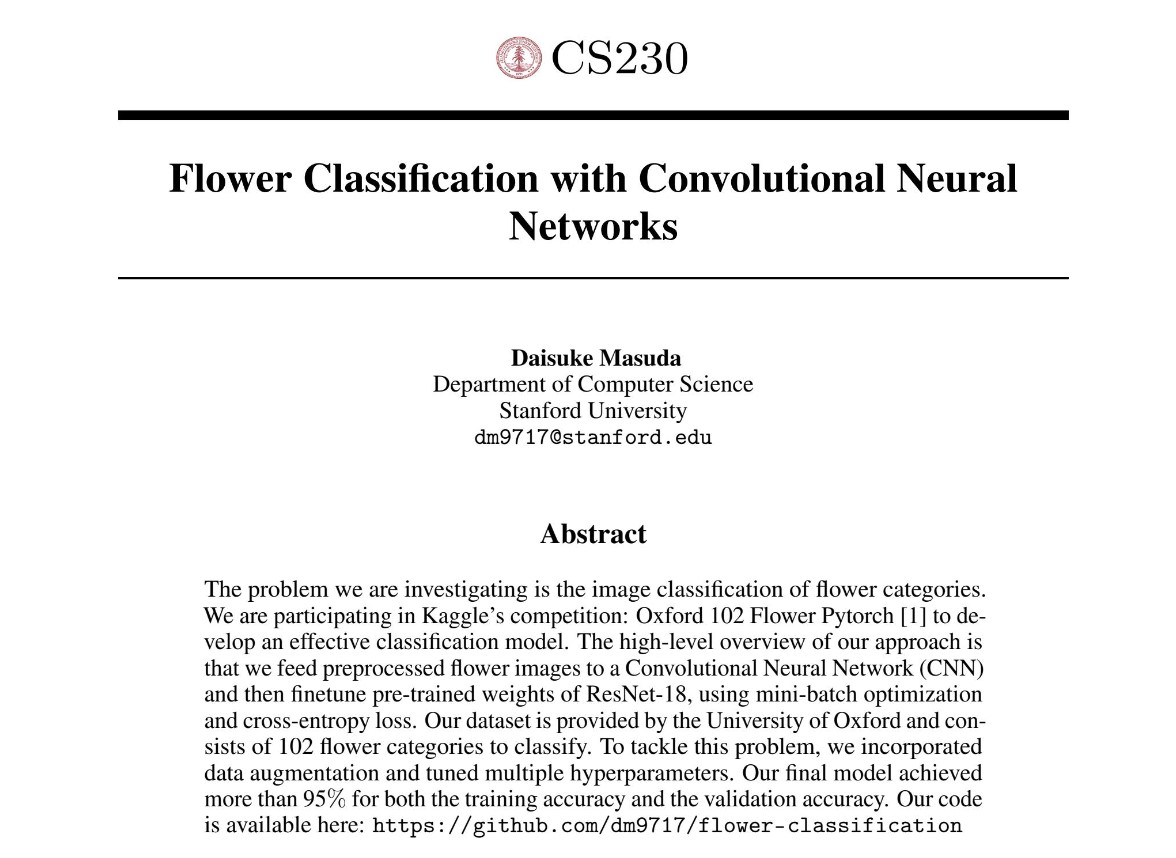

# 2. Introduction
Plant diseases are mainly caused by parasites such as fungi, viruses, bacteria, among others. The response of each plant to diseases is varied, so the correct diagnosis is sometimes complicated if the plant caretaker does not have sufficient knowledge to attack the problem. In agriculture, it is of vital importance to be able to make a diagnosis in time to avoid the spread of diseases and to prevent their reappearance in the future. In Colombia, the Ministry of Agriculture and Rural Development does not provide training to farmers for the correct diagnosis and management of plant diseases, which hinders the disease eradication process. Considering the above, it is important to have models that can be used by farmers (and non-experts in general) for the diagnosis of diseases in all types of plants, and thus be able to reduce the negative impacts on Colombian plantations. In this project we use the data of 7 diseases in mango plants to train a ResNet-18 that has a Softmax activation function at the end that gives us a vector with 8 entries where each one represents the probability that the image has a disease or is healthy.

# 3. State of the art
1. [Plant leaf disease classification and damage detection system using deep learning models](https://link.springer.com/article/10.1007/s11042-022-12147-0). They use a DenseNet and a CNN for the classification of diseases in plants grown in India (apple, grape, potato and strawberry). After identifying the disease, they propose a treatment or remedy.
2. [ResNet-based approach for Detection and Classification of Plant Leaf Diseases](https://ieeexplore.ieee.org/document/9155585). Using an open data set of 15200 images of healthy and diseased plants they train a ResNet-34 obtaining an accuracy of 99.4% on the test set.  
3. [A modern approach for plant leaf disease classification which depends on leaf image processing](https://ieeexplore.ieee.org/abstract/document/8117733). Using computer vision techniques, they extract important features in certain plant diseases that allow their identification without the need for a neural network model.


# 4. Data set
- Type of data: 240x320 and 240x240 mango leaf images.
- Data format: JPG.
- Number of images: 4000 images. Of these, around 1800 are of distinct leaves, and the rest were prepared by zooming and rotating where deemed necessary (data augmentation).
- Diseases considered: Seven diseases, namely Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Powdery Mildew, and Sooty Mould.
- Number of classes: Eight (including the healthy category).
- Distribution of instances: Each of the eight categories contains 500 images.
- How data are acquired: Captured from mango trees through the mobile phone camera.
- Data source locations: Four mango orchards of Bangladesh, namely Sher-e-Bangla Agricultural University orchard, Jahangir Nagar University orchard, Udaypur village mango orchard, and Itakhola village mango orchard.

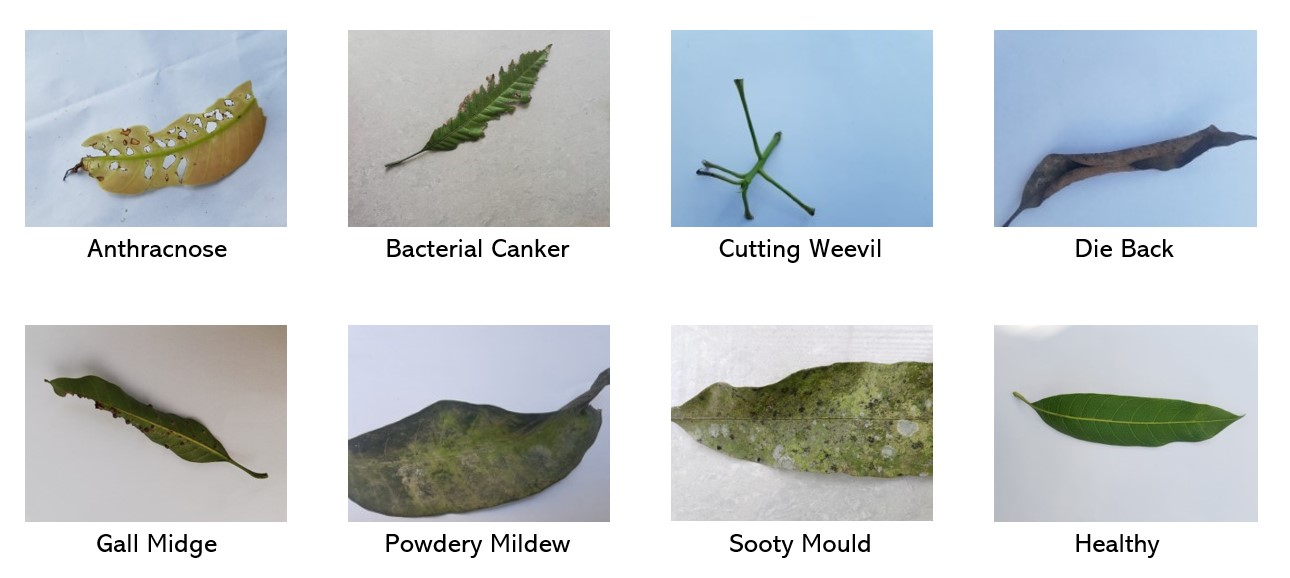

# 5. Network acrhitecture
## 5.1 ResNet-18
ResNet-18 is a convolutional neural network that is 18 layers deep and implements residual block of the identity function to overcome the problem of vanishing gradients. We will be using the [Pytorch implementation](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights) of this CNN with its pre-trained weights (IMAGENET1K_V1) which was trained with the ImageNet data set. 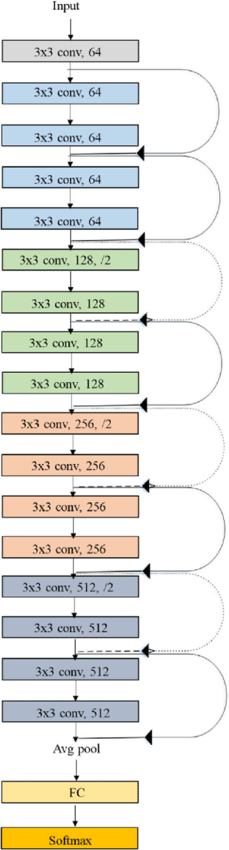

## 5.2 Transfer learning
There exists two types of transfer learning:
1. Finetuning the ConvNet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
2. ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

Since the ResNet-18 is a *small* ConvNet and we have a good amount of data for each of the diseases, we will be using the first type of transfer learning in our problem.

## 5.3 Metric to evaluate the model
Since the data set is balanced in all its classes, we will use accuracy to test the model performance in each set (train, validation and test). The accuracy is defined as
$$\begin{align*}
Accuracy = \frac{\text{Total number of samples the model predicted well}}{\text{Total number of samples}}.
\end{align*}
$$

# 6. Model implementation

In [1]:
from __future__ import print_function, division

import splitfolders
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

cudnn.benchmark = True
plt.ion()   # interactive mode
# Creates a runs/baseline_resnet18_dataaugmented folder
writer = SummaryWriter("TensorBoard/runs/resnet18")

##  6.1 Organize and load data

In [4]:
# Split with a ratioof  80% to training set and 10% for validation and test set
splitfolders.ratio("images", output="data", seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 4000 files [00:03, 1026.96 files/s]


In [2]:
# Data normalization and re-scaling for each of the sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((240,240)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
data_dir = 'data/'

# Get data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}

# Load data into gpu
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 6.1.1 Visualize some examples

In [4]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

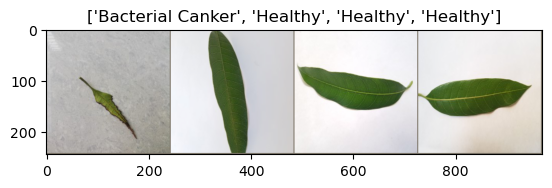

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 6.2 Create model

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            batch_index = 0
            for inputs, labels in tqdm(dataloaders[phase]):
                # Move the data to the proper device (GPU or CPU)
                inputs = inputs.to(device) 
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                batch_loss = loss.item() * inputs.size(0)
                running_loss += batch_loss
                batch_corrects = torch.sum(preds == labels.data).item()
                running_corrects += batch_corrects
                
                # Write the loss and accuracy to TensorBoard
                writer.add_scalar('Loss/' + phase, batch_loss, epoch * len(dataloaders[phase]) + batch_index)
                writer.add_scalar('Accuracy/' + phase, batch_corrects / inputs.size(0), epoch * len(dataloaders[phase]) + batch_index)
                
                batch_index += 1
            # lr_scheduler provides several methods to adjust the learning rate based on the number of epochs
            if phase == 'train':
                scheduler.step()
                
            # Loss and accuracy of the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    writer.flush()
    return model

###  6.2.1 Visualize model predictions

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}\n real-class: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

###  6.2.2 Finetune the ResNet Model

In [9]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features

num_classes = 8
# Here the size of each output sample is set to 8.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes) 

model_ft = model_ft.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 6.3 Train and evaluate model

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


100%|██████████| 800/800 [00:19<00:00, 40.64it/s]


train Loss: 0.4426 Acc: 0.8581


100%|██████████| 100/100 [00:02<00:00, 34.31it/s]


val Loss: 0.0531 Acc: 0.9800

Epoch 1/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.07it/s]


train Loss: 0.1622 Acc: 0.9484


100%|██████████| 100/100 [00:02<00:00, 34.05it/s]


val Loss: 0.0143 Acc: 0.9950

Epoch 2/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.03it/s]


train Loss: 0.1205 Acc: 0.9675


100%|██████████| 100/100 [00:02<00:00, 35.08it/s]


val Loss: 0.0285 Acc: 0.9900

Epoch 3/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.20it/s]


train Loss: 0.0707 Acc: 0.9800


100%|██████████| 100/100 [00:02<00:00, 34.32it/s]


val Loss: 0.0038 Acc: 1.0000

Epoch 4/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.01it/s]


train Loss: 0.0766 Acc: 0.9806


100%|██████████| 100/100 [00:02<00:00, 34.66it/s]


val Loss: 0.0170 Acc: 0.9950

Epoch 5/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.49it/s]


train Loss: 0.0567 Acc: 0.9838


100%|██████████| 100/100 [00:02<00:00, 34.91it/s]


val Loss: 0.0019 Acc: 1.0000

Epoch 6/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.27it/s]


train Loss: 0.0481 Acc: 0.9841


100%|██████████| 100/100 [00:02<00:00, 33.91it/s]


val Loss: 0.0020 Acc: 1.0000

Epoch 7/9
----------


100%|██████████| 800/800 [00:16<00:00, 49.26it/s]


train Loss: 0.0391 Acc: 0.9906


100%|██████████| 100/100 [00:02<00:00, 34.38it/s]


val Loss: 0.0008 Acc: 1.0000

Epoch 8/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.87it/s]


train Loss: 0.0160 Acc: 0.9956


100%|██████████| 100/100 [00:02<00:00, 34.68it/s]


val Loss: 0.0005 Acc: 1.0000

Epoch 9/9
----------


100%|██████████| 800/800 [00:16<00:00, 48.67it/s]


train Loss: 0.0163 Acc: 0.9962


100%|██████████| 100/100 [00:02<00:00, 34.19it/s] 

val Loss: 0.0004 Acc: 1.0000

Training complete in 3m 17s
Best val Acc: 1.000000


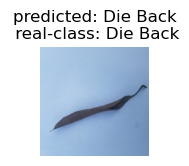

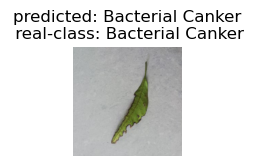

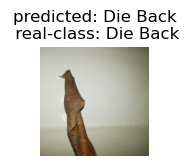

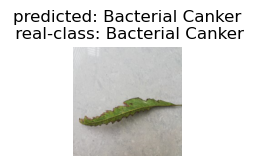

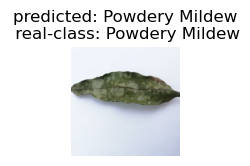

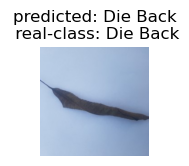

In [11]:
visualize_model(model_ft)

In [12]:
# Save model
torch.save(model_ft.state_dict(), "model/final-model.pth")

##  6.4 Loss and accuracy plots

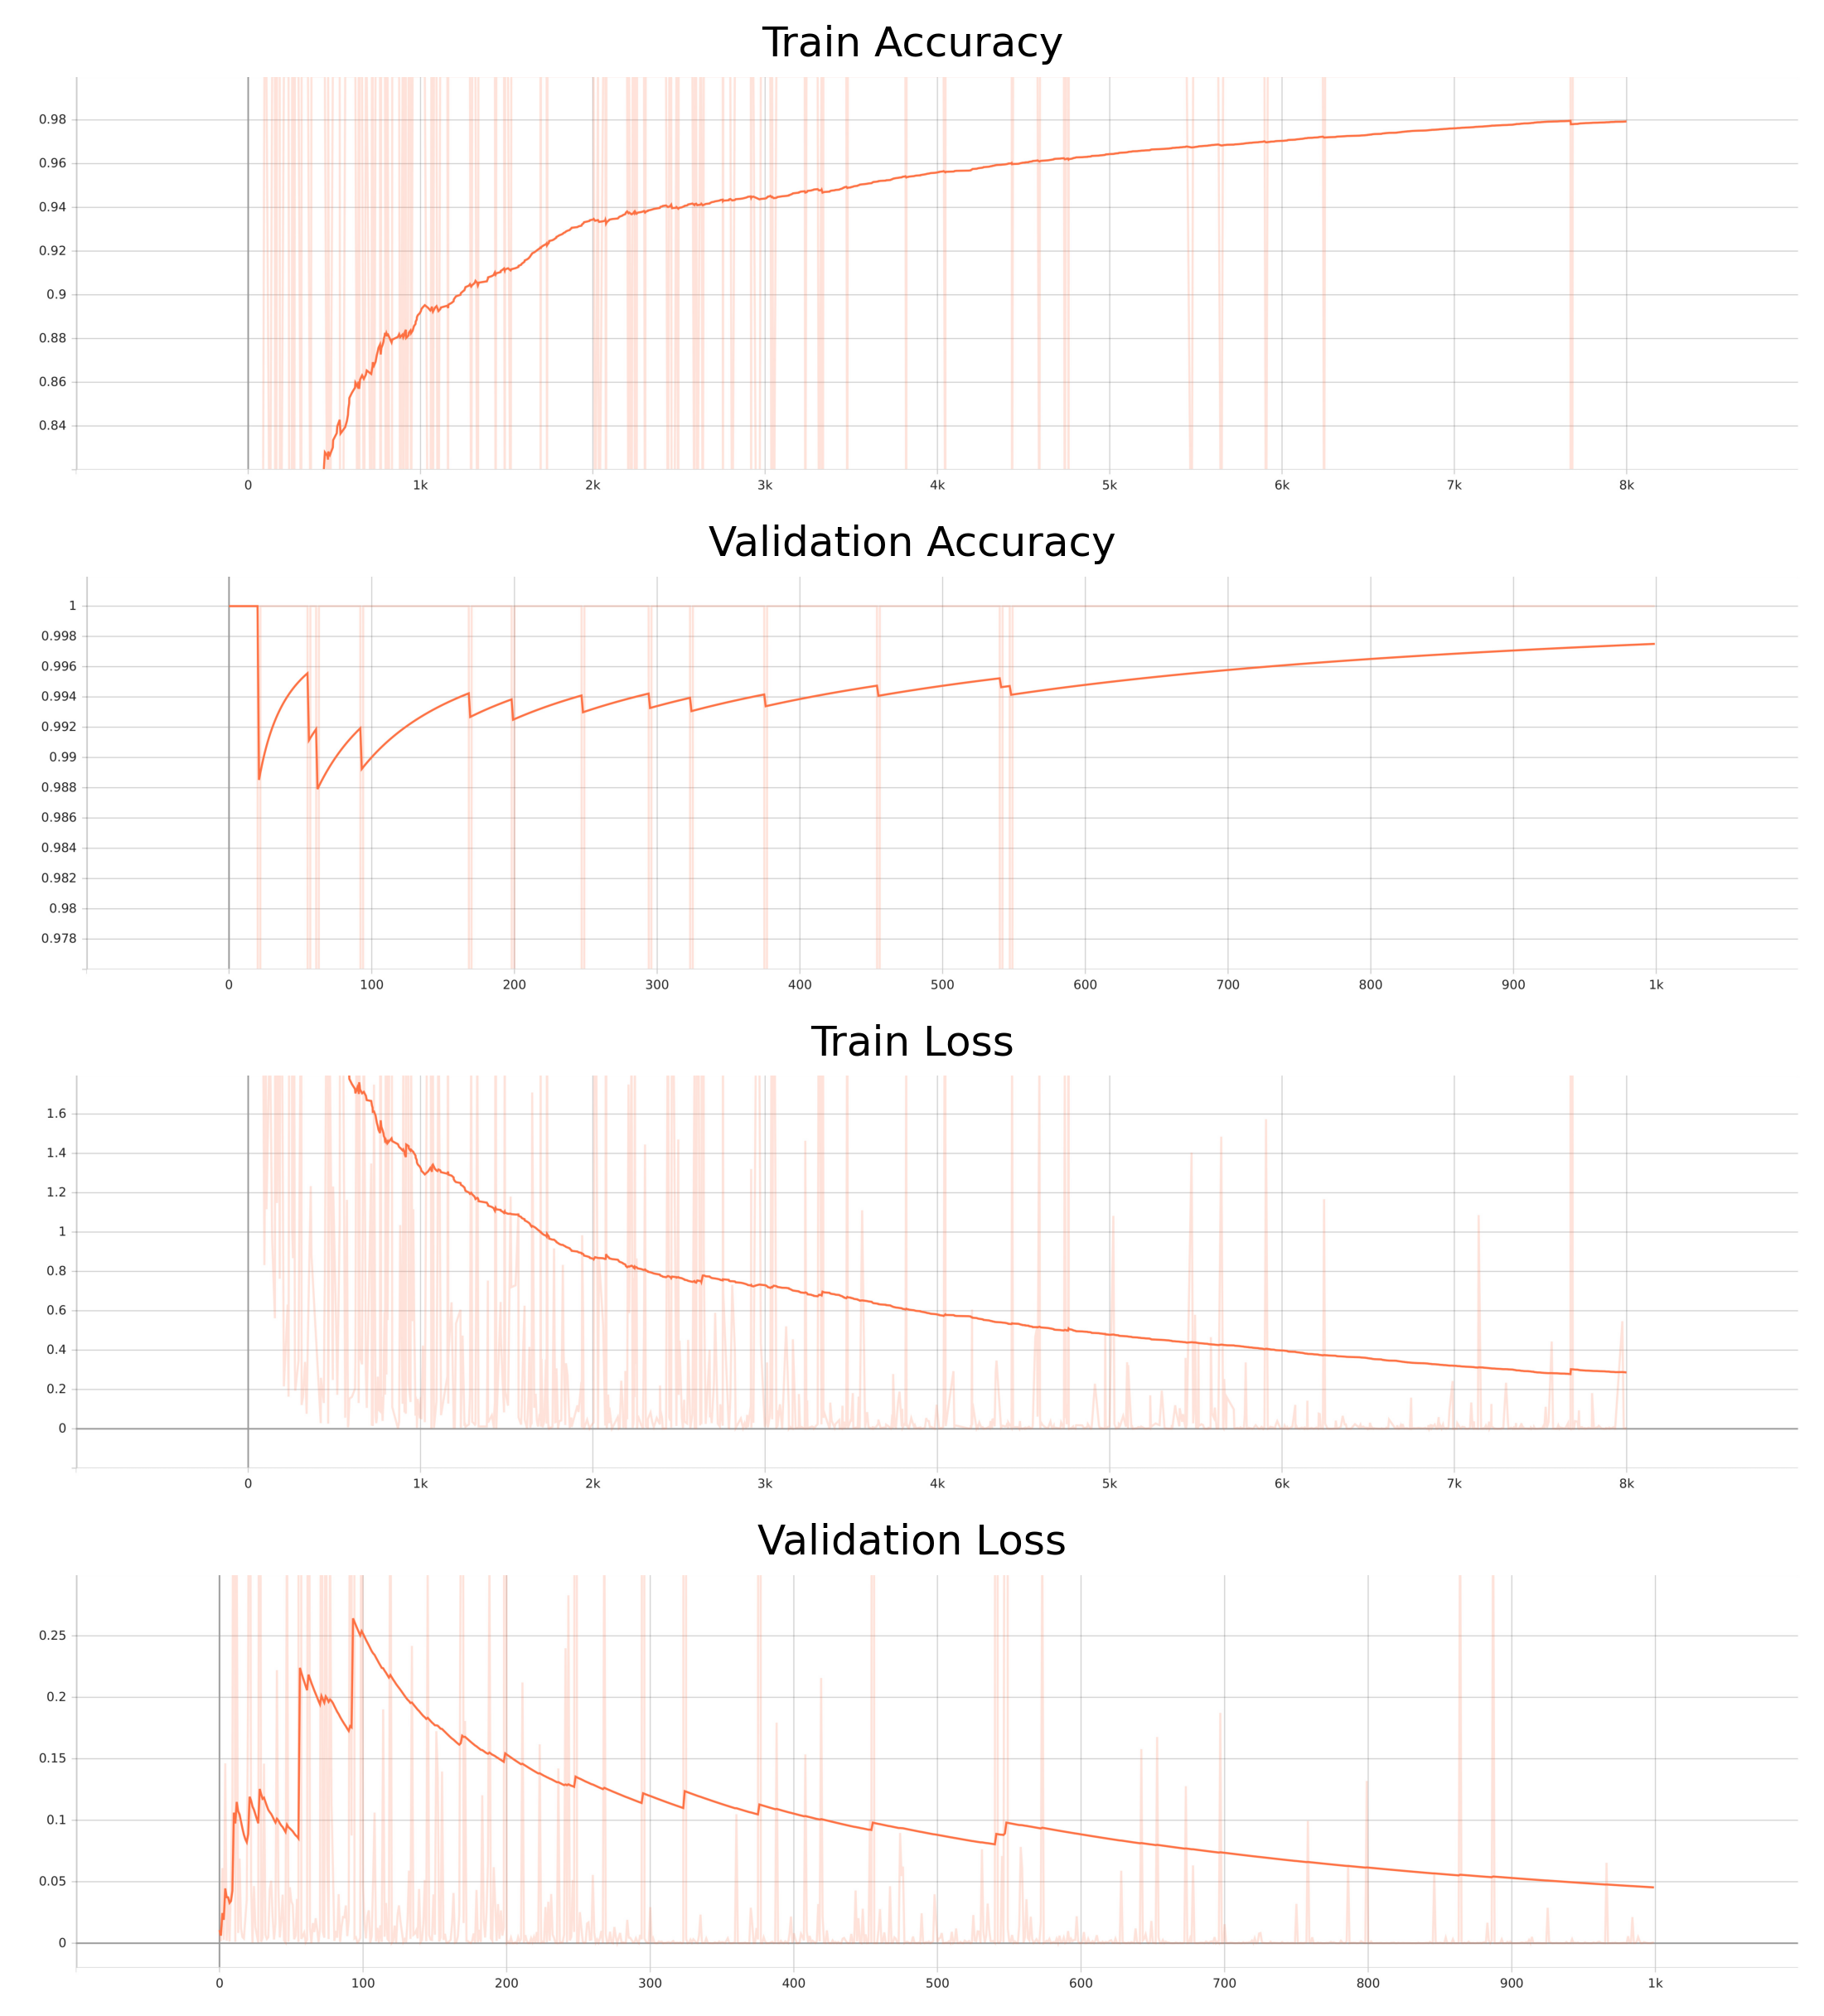

In [12]:
import os
graphs = os.listdir('loss-accuracy-plots')
graphs = ['loss-accuracy-plots/'+graph for graph in graphs]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


figure, axis = plt.subplots(nrows=4, ncols=1, figsize=(30,10))
titles = ['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss']
i = 0
for graph in graphs:
    axis[i].imshow(plt.imread(graph))
    axis[i].axis('off')
    axis[i].title.set_text(titles[i])
    i += 1

The graphs above show the behavior of accuracy and loss in the test and validation sets. These plots show how the accuracy is increasing while the loss is decreasing in each of the 10 training epochs. To generate these plots, we evaluated the model at the end of each epoch in both sets. The best accuracy in training was 99.62% and in validation was 100%. In the case of loss, we obtained 0.16% in training and 0.004% in validation. 

## 6.5 Accuracy in test set

In [28]:
# Make a matrix whose row represents true labels and column represents prediction labels
def create_prediction_matrix(model, dataset, num_images, batch_size):
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) 
                   for x in ['train', 'val', 'test']}
    
    was_training = model.training
    model.eval()
    images_so_far = 0

    prediction_matrix = np.zeros((num_classes, num_classes)).astype(int)

    with torch.no_grad():
        for i, (inputs, labels) in tqdm(enumerate(dataloaders[dataset])):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Iterate through predictions for one batch
            for j in range(inputs.size()[0]):
                prediction_matrix[labels[j]][preds[j]] += 1        
                images_so_far += 1

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return prediction_matrix
        model.train(mode=was_training)
        return prediction_matrix

In [29]:
def visualize_matrix(matrix, img_name):
    plt.figure(figsize = (100, 100))
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.matshow(matrix)
    plt.xlabel("Predicted Labels", fontsize=16)
    plt.ylabel("True Labels", fontsize=16)
    plt.title("Prediction Results", fontsize=24)
    plt.xticks(ticks=np.arange(0, 8), labels=class_names, rotation="vertical", fontsize=15)
    plt.yticks(ticks=np.arange(0, 8), labels=class_names, fontsize=15)
    ax = plt.gca()
    ax.xaxis.set_ticks_position("bottom")
    
    for i in range(num_classes):
        for j in range(num_classes):
            if matrix[i, j] != 0:
                text = ax.text(j, i, matrix[i, j], ha="center", va="center", color="black", fontsize=20)
    
    plt.savefig(img_name) 
    plt.show()

In [30]:
prediction_matrix = create_prediction_matrix(model_ft, 'test', 400, 4)

99it [00:02, 41.13it/s] 


<Figure size 30000x30000 with 0 Axes>

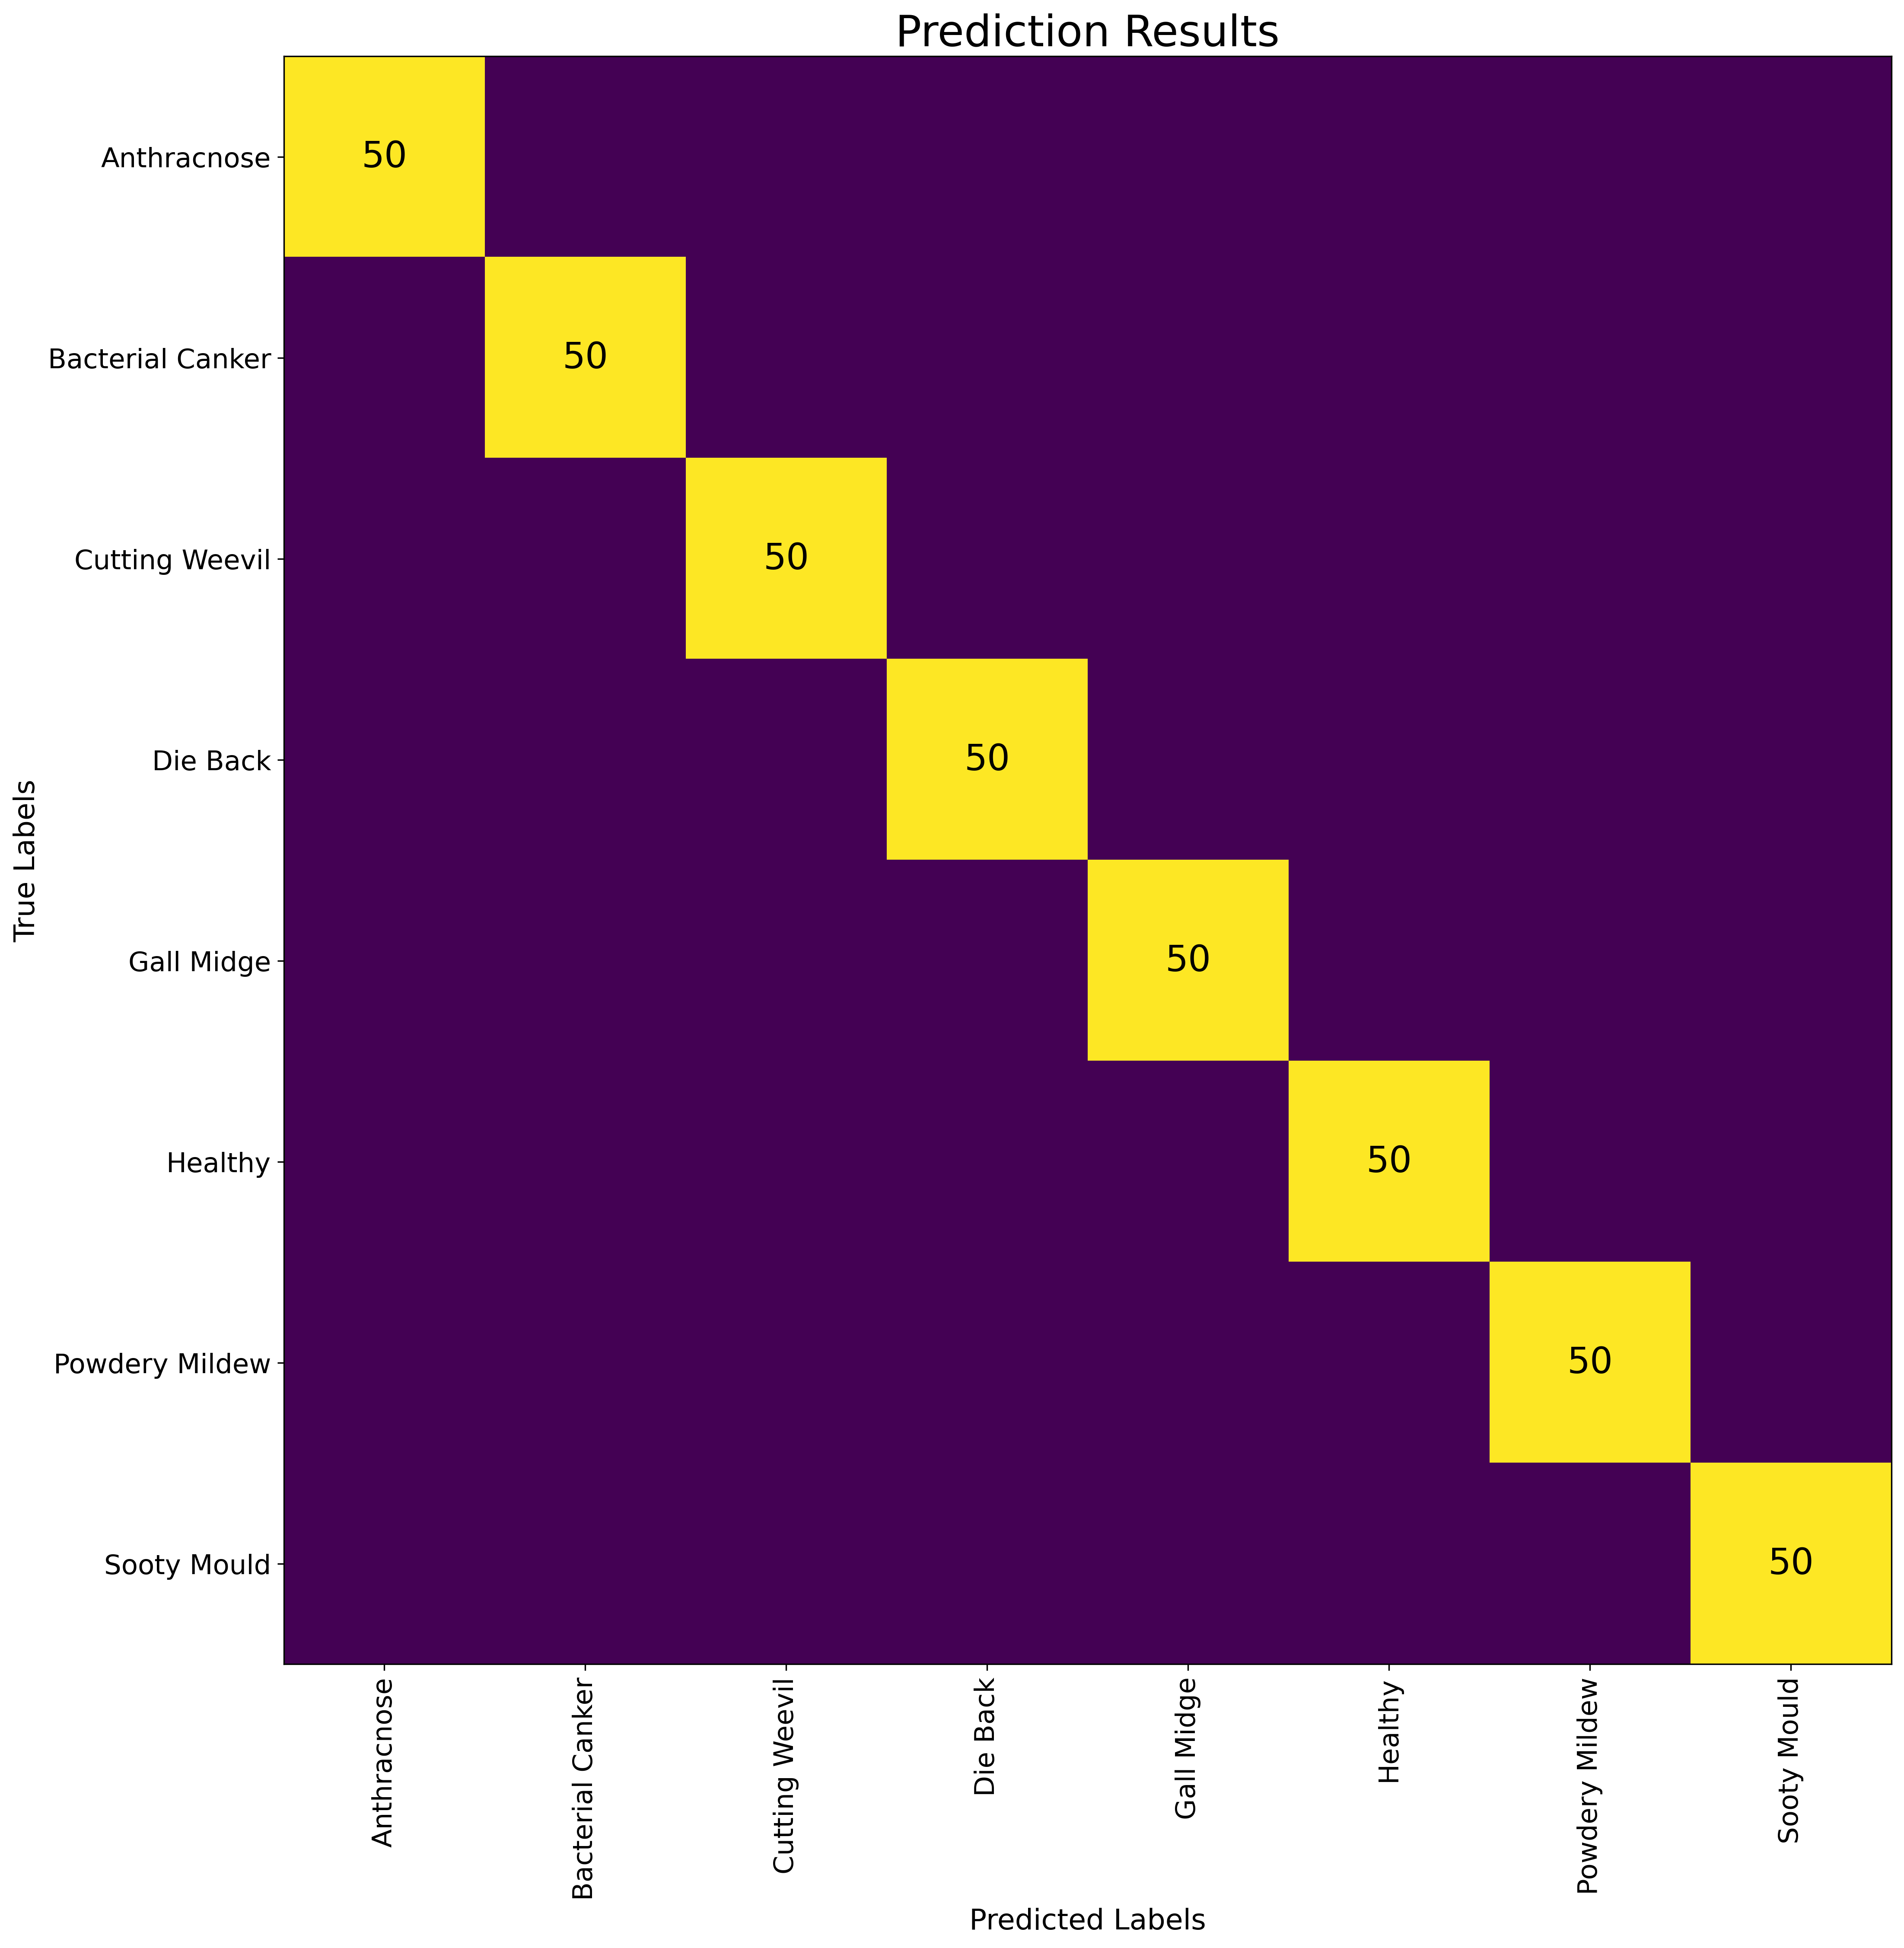

In [31]:
visualize_matrix(prediction_matrix, 'confusion_matrix.png')

# 7. Conclusions
1. Taking into account the results obtained, the model can be trained in the future with more diseases of different types of plants. The Colombian government should bet on this type of initiatives for the improvement of processes in the agricultural sector.

2. Transfer learning is a very powerful tool that can help us to solve problems in a simpler way because in most cases just by doing transfer learning of type 2 (which is faster than the one we implemented in this project) gives good results.

3. The use of GPU in CNN training (and NN in general) is almost mandatory, the CPU process is quite slow even with small models.

# 8. Bibliography
1. Ali, Sawkat; Ibrahim, Muhammad ; Ahmed, Sarder Iftekhar ; Nadim, Md. ; Mizanur, Mizanur Rahman; Shejunti, Maria Mehjabin ; Jabid, Taskeed (2022), “MangoLeafBD Dataset”, Mendeley Data, V1, doi: 10.17632/hxsnvwty3r.1.
2. Chilamkurthy, S. (n.d.). Transfer Learning for Computer Vision Tutorial. Retrieved from Pytorch: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
3. Solares, N. (2021, 09 14). Why proper identification of plant diseases matters and how we can assist farmers. Retrieved from Small Farm News for San Bernardino and Riverside Counties: https://ucanr.edu/blogs/blogcore/postdetail.cfm?postnum=50453.
4. Pytorch. (n.d.). resnet18. Retrieved from Pytorch Documentation: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html
